# End-to-end Solar Out-of-Distribution (SOoD) pipeline

This notebook presents an end-to-end training and prediction pipeline for Anomaly Detection with a context-encoding variational autoencoder.

The model is based on the following paper: Zimmerer, David, et al. "Context-encoding variational autoencoder for unsupervised anomaly detection." arXiv preprint arXiv:1812.05941 (2018).

## Data Acquisition

Make sure to run the setup and install `sdo-cli` first (`make setup` and `make install`).

In [1]:
# download the dataset

!sdo-cli data download --path='./data/aia_171_2012' \
    --start='2012-01-01T00:00:00' \
    --end='2012-01-31T23:59:00' \
    --freq='12h' \
    --wavelength='171'

Starting to download images...
loading data for 62 images between 2012-01-01 00:00:00 and 2012-01-31 23:59:00


In [2]:
# resize the images to 256x256

!sdo-cli data resize --path='./data/aia_171_2012' \
    --targetpath='./data/aia_171_2012_256/train' \
    --size="256" \
    --wavelength='171'

Starting to generate resized images...
converting 62 images


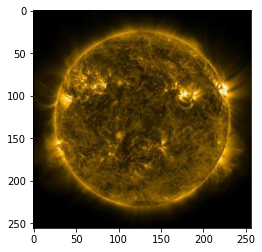

In [4]:
#inspect an image

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os 

data_dir = "./data/aia_171_2012_256/train"
aia_wave = 171
images = list(Path(data_dir).rglob(f'*__{aia_wave}.jpeg'))
img_path = images[0]

src_img = Image.open(img_path)
plt.imshow(np.asarray(src_img))

## Training

For a visual inspection of the training process start a [Visdom Server](https://github.com/fossasia/visdom): `make visdom`. Head over to [http://localhost:8080](http://localhost:8080) and start the training:

In [4]:
# training a ceVAE model for the downloaded images (note that a much larger dataset should be used in practice)

output_dir = "./output/train"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

!sdo-cli sood ce_vae train \
    --target-size=256 \
    --data-dir="./data/aia_171_2012_256" \
    -o "./output/train"\
    --logger "file" \
    --ce-factor 0.5 \
    --score-mode combi \
    --n-epochs 10

VAE(
  (enc): BasicEncoder(
    (start): ConvModule(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (middle_blocks): ModuleList(
      (0): NoOp()
      (1): ConvModule(
        (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): NoOp()
      (3): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (4): NoOp()
      (5): ConvModule(
        (conv): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
    (end): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=[16, 16], stride=(1, 1), bias=False)
    )
  )
  (dec): BasicGenerator(
    (start): ConvModule(
    

## Predict

In [5]:
# download a test sequence

!sdo-cli data download \
    --path='./data/aia_171_2012_full_disk_flare' \
    --start='2012-03-07T00:02:00' \
    --end='2012-03-07T00:40:00' \
    --freq='6min' \
    --wavelength='171'

!sdo-cli data resize \
    --path='./data/aia_171_2012_full_disk_flare' \
    --targetpath='./data/aia_171_2012_full_disk_flare_256/test' \
    --wavelength='171' \
    --size=256

Starting to download images...
loading data for 7 images between 2012-03-07 00:02:00 and 2012-03-07 00:40:00
Starting to generate resized images...
converting 7 images


In [2]:
import os, glob

def find_newest_dir(pattern):
    newest_dir = max(glob.glob(pattern), key=os.path.getmtime)
    print(newest_dir)
    return newest_dir

In [7]:
# pixel-level predictions

import os 

train_path = find_newest_dir('./output/train/*/')
load_path = train_path / Path('checkpoint')

pred_output_dir = "./output/pred"
if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
!sdo-cli sood ce_vae predict \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/pred' \
    --logger "file" \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="pixel"

./output/train/20210806-145247_cevae/
VAE(
  (enc): BasicEncoder(
    (start): ConvModule(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (middle_blocks): ModuleList(
      (0): NoOp()
      (1): ConvModule(
        (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): NoOp()
      (3): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (4): NoOp()
      (5): ConvModule(
        (conv): Conv2d(256, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
    )
    (end): ConvModule(
      (conv): Conv2d(1024, 256, kernel_size=[16, 16], stride=(1, 1), bias=False)
    )
  )
  (dec): BasicGe

./output/pred/20210806-153421_cevae/


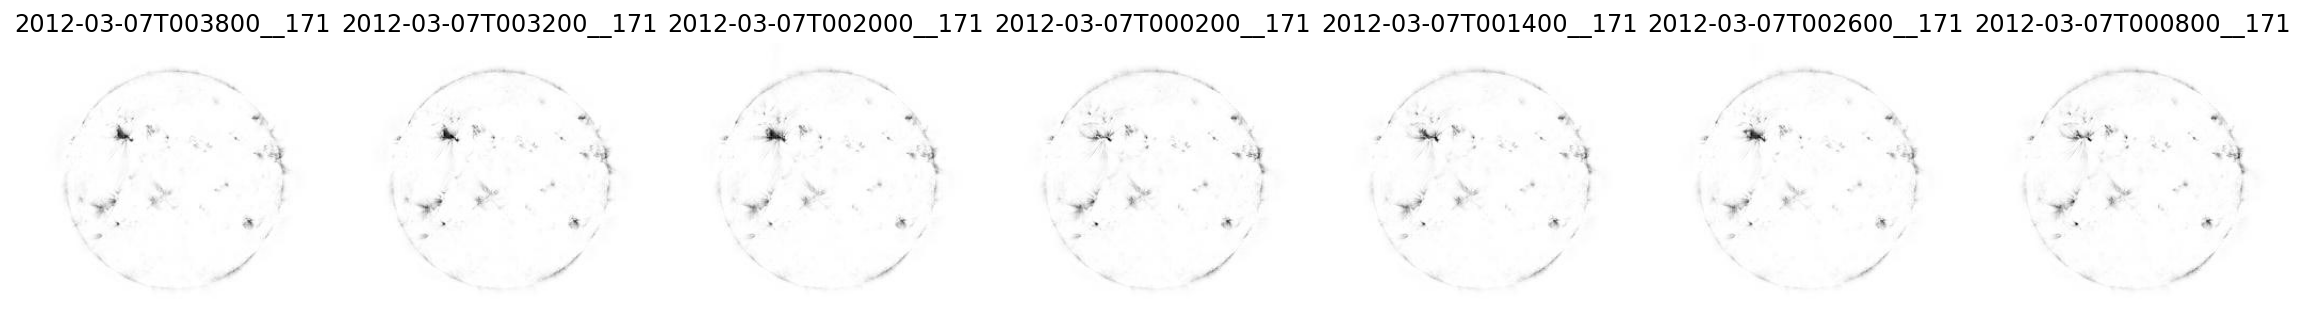

In [8]:
# display inverted pixel-wise anomaly scores

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 

aia_wave = 171
newest_dir = find_newest_dir('./output/pred/*/')
pixel_pred_path =  newest_dir / Path("predictions")
images = list(Path(pixel_pred_path).rglob(f'*__{aia_wave}.jpeg'))

f, axarr = plt.subplots(1,7, figsize=(20, 9))

row_index = 0
column_index = 0

for index, path in enumerate(images):
    img = Image.open(path)
    img_arr = np.invert(np.asarray(img))
    axarr[column_index].set_title(path.stem)
    axarr[column_index].imshow(img_arr, cmap='gray', vmin=0, vmax=255)
    axarr[column_index].spines['top'].set_visible(False)
    axarr[column_index].spines['right'].set_visible(False)
    axarr[column_index].spines['bottom'].set_visible(False)
    axarr[column_index].spines['left'].set_visible(False)
    axarr[column_index].xaxis.set_ticks([])
    axarr[column_index].yaxis.set_ticks([])

    if(column_index == 6):
        row_index = (row_index + 1)
        
    column_index = (column_index + 1) % 7

In [10]:
# sample-level predictions

!sdo-cli sood ce_vae predict \
    --target-size=256 \
    --data-dir='./data/aia_171_2012_256' \
    --test-dir='./data/aia_171_2012_full_disk_flare_256' \
    --load-path={load_path} \
    -o './output/pred' \
    --logger "file" \
    --ce-factor 0.5 \
    --score-mode combi \
    --mode="sample"

Setting up a new session...
Connection to remote host was lost.
Connection to remote host was lost.
Connection to remote host was lost.
Visdom python client failed to establish socket to get messages from the server. This feature is optional and can be disabled by initializing Visdom with `use_incoming_socket=False`, which will prevent waiting for this request to timeout.
VAE(
  (enc): BasicEncoder(
    (start): ConvModule(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (middle_blocks): ModuleList(
      (0): NoOp()
      (1): ConvModule(
        (conv): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): NoOp()
      (3): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activation): LeakyReLU(negative_slope=0.01)
      

In [11]:
# investigate sample-wise scores

import pandas as pd

newest_dir = find_newest_dir('./output/pred/*/')
sample_pred_path =  newest_dir / Path("predictions/predictions.txt")

df = pd.read_csv(sample_pred_path, header=None, names = ["img", "score"])
df.head(7)

./output/pred/20210806-153701_cevae/


,img,score
0,2012-03-07T000200__171.jpeg,0.061711
1,2012-03-07T000800__171.jpeg,0.062153
2,2012-03-07T001400__171.jpeg,0.063175
3,2012-03-07T002000__171.jpeg,0.072101
4,2012-03-07T002600__171.jpeg,0.070350
5,2012-03-07T003200__171.jpeg,0.062748
6,2012-03-07T003800__171.jpeg,0.066110


In [12]:
df.describe()

,score
count,7.000000
mean,0.065478
std,0.004203
min,0.061711
25%,0.062451
50%,0.063175
75%,0.068230
max,0.072101
